# Task 3

## Line fitting and clustering

Use robust fitting to:
- Identify in the picture the dominant lines in the scene
- Cluster together the line in the picture that are parallel in the scene

### TASK OVERVIEW

To carry out this task, I will set up a RanSaC algorithm to find the vanishing points of clusters of parallel lines. <br>
More specifically, I will follow these steps:
- Slight blurring of the image
- Application of Canny Filter to produce a map of the edges of the image
- Application of Hough Transform to extract relevant lines from the edge map (the lines returned are in polar coordinates)
- Conversion of the lines from polar coordinates to standard form, in order to have a duality correspondence between points in homogeneous coordinates and lines.
- Application of Sequential RanSaC algorithm in the dual space (the points are lines in the original space, and fitting a line between two points means intersecting two lines in the original space) to robustly obtain vanishing points and dominant lines in a sequential fashion.
- Separation of the dominant lines into clusters based on their vanishing point.

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
from scipy.stats import linregress


In [2]:
image = cv2.imread('data/villa.png')

### SELECTION OF PARAMETERS FOR CANNY FILTER

Here I try to find the best balance of parameters to obtain a satisfactory edge map, so that it preserves relevant edges while removing noisy features, like for instance leaves of the two trees in the front of the picture.
For instance, I explore 4 parameter choices:
- The Gaussian Filter dimension (in the function *GaussianBlur*)
- The Gaussian Filter standard deviation (in the function *GaussianBlur*)
- The thresholds for the hysteresis procedure in the *cv2.Canny* function


In [17]:
def plot_grid(image, param_list):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for i, params in enumerate(param_list):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img = cv2.GaussianBlur(gray, (params[0], params[0]), params[1])
        edges = cv2.Canny(img, params[2], params[3], apertureSize=3)
        ax = axes[i // 3, i % 3]
        ax.imshow(edges, cmap='gray')
        ax.axis('off')
    plt.show()


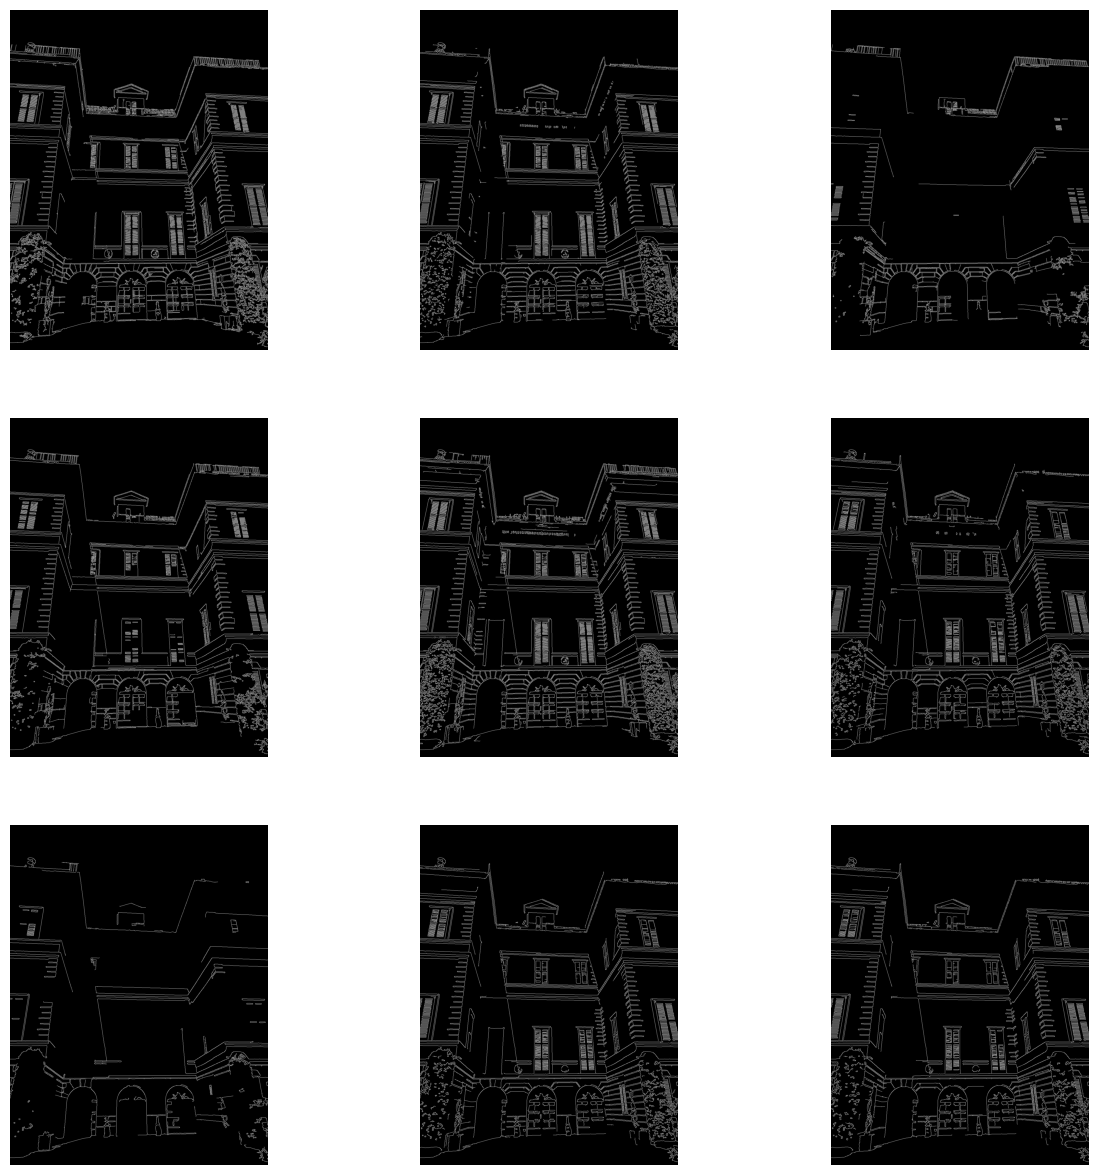

In [4]:
param_list = [[3, 0, 10, 300],
              [3, 1.5, 100, 200], 
              [3, 1.5, 10, 500],
              [5, 0, 10, 300],
              [5, 0, 50, 150],
              [5, 1.5, 50, 150],
              [7, 0, 10, 300],
              [7, 0, 50, 150],
              [7, 1.5, 50, 150]]

plot_grid(image, param_list)

After this analysis, the best choice for the task seems to be a Gaussian Filter of size 7x7 because it allows for an optimal blur level, since the relevant edges of the house are maintained, but some of the noisy edges given by the plants' leaves are toned down.
However, the choice of parameters of the 7th picture is surely not optimal, since it removes a good portion of the important edges of the image, therefore we will choose the parameters corresponding to the 9th picture.

### SELECTION OF PARAMETERS FOR HOUGH TRANSFORM AND LINE SELECTION

The set of parameters which I will try to optimize in this seciton are the ones of the Hough Transform. The parameters influence the number of lines that will be selected and the accuracy with which are selected, at the expense of memory use and computational time. As always I will try to strike a good balance between a high number of well-detected lines, and a small overhead.

In [18]:
def extract_lines(image, kernel, sigma, rho, theta, threshold):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(gray, (kernel, kernel), sigma)
    edges = cv2.Canny(img, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, rho=rho, theta=theta, threshold=threshold)
    
    return lines[:, 0]

def plot_grid(list_of_lines):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i, lines in enumerate(list_of_lines):
        ax = axes[i // 3, i % 3]
        ax.imshow(image[:, :, ::-1])
        ax.axis('off')
        if lines is not None:
            for rho, theta in lines:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                x1 = int(x0 + 1500 * (-b))
                y1 = int(y0 + 1500 * (a))
                x2 = int(x0 - 1500 * (-b))
                y2 = int(y0 - 1500 * (a))
                ax.plot([x1, x2], [y1, y2], color='r', linewidth=1)
        ax.set_xlim(0, image.shape[1])
        ax.set_ylim(image.shape[0], 0)
    plt.tight_layout()
    plt.show()
    return list_of_lines

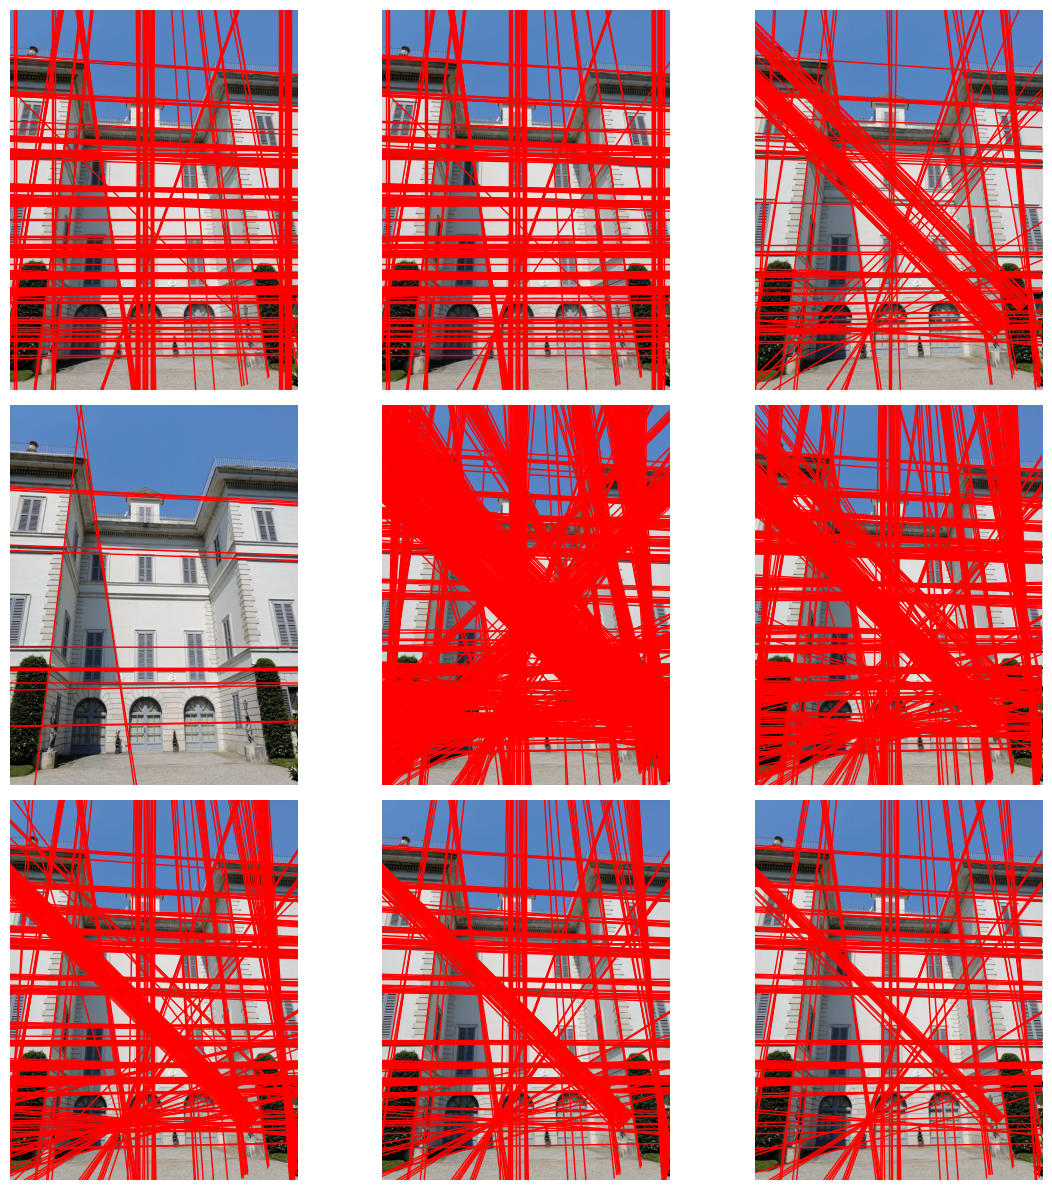

In [19]:
param_list = [
    (7, 1.5, 0.5, np.pi/1000, 120),
    (7, 1.5, 0.5, np.pi/1080, 120),
    (5, 0, 1, np.pi/180, 230),
    (5, 0, 1, np.pi/180, 300),
    (5, 0, 1, np.pi/360, 200),
    (7, 1.5, 1, np.pi/360, 150),
    (7, 1.5, 1, np.pi/360, 160),
    (7, 1.5, 1, np.pi/360, 170),
    (7, 1.5, 1, np.pi/360, 180)
]

list_of_lines = [extract_lines(image, *params) for params in param_list]

_ = plot_grid(list_of_lines)

As can be seen from this list of images, a selection of the threshold that is too low can lead to a huge number of lines, while a threshold that is too high can lead to a number of lines that is too small. <br>
It is worth remarking that, with a lower $\rho$ and $\theta$ parameters, the lines found by the Hough Transform are much slightly more precise (see Picture 1 (top left corner) and Picture 2 (first row, second column)), while for bigger values the lines are more imprecise. <br>
For instance, pictures that have higher values of these two parameters exhibit a big number of lines across the two diagonals, which are not lines correspoonding to actual lines in the pictures, but which are generate from the noisy edges detected by the Canny filter on the plants.

### SEQUENTIAL RANSAC ALGORITHM AND VANISHING POINTS ESTIMATION.

In this section, I will write the function to perform the robust fitting using the RanSaC algorithm, and then I will try different sets of initial parameters for the Hough Transform to try to see which one leads to a better fitting. <br>
Let me remark that the RanSaC algorithm will be applied on points in the dual projective space and will try to estimate the dual line with greatest consensus. Obviously, points in the dual space correspond to lines in the original space, and lines in the dual space correspond to points in the original space, therefore what the algorithm does (in the original space) is effectively finding the point which is the intersection point of as many lines as possible. <br>
By applying the algorithm in a sequential way, we are able to obtain clusters of dual points (i.e. lines in the original space) and the lines passing though each cluster (i.e. the intersection point in the original space). In doing so, since we expect dominant lines to be parallel to the three axes, we expect to find the vanishing points of the three orthogonal dimensions.

In [5]:
def fit_line_ransac(points, threshold=0.005, confidence=0.99,score_method='consensus'):
    best_vanishing_point = None
    best_inliers = []
    best_score = 0
    inlier_fraction = 0.1
    mss_size = 3
    min_iterations = 10
    num_points = points.shape[0]
    i = 0
    np.random.seed(1)
    while i < max(math.ceil(math.log(1-confidence)/math.log(1-inlier_fraction**mss_size)), min_iterations):
        # Randomly sample 2 points to form a line
        sample_idx = np.random.choice(num_points, (2), replace=False)
        while sample_idx[0] == sample_idx[1]:  
            sample_idx = np.random.choice(num_points, (2), replace=False)
        sample_points = points[sample_idx]
        
        # Fit a line using the 2 randomly sampled points
        fitted_line = np.cross(sample_points[0], sample_points[1])
        
        # Compute distance from all points to the fitted line
        distances = distance_point_to_line(points, fitted_line)

        # Get inliers 
        inliers, score = score_inliers(num_points, residuals=distances, threshold=threshold, method=score_method)

        # Update best model if this model has more inliers
        if score > best_score:
            
            # Refitting on inliers to speed up convergence
            inlier_pts = points[inliers]
            
            # Fit a line through the inliers
            new_line = fit_line(inlier_pts)

            # Compute distance from all points to the line
            distances = distance_point_to_line(points, new_line)

            # Get inliers (points within threshold distance from the circle)
            inliers, score = score_inliers(
            num_points, residuals=distances, threshold=threshold, method=score_method)

            best_line = new_line
            best_inliers = inliers
            best_score = score

            # Update inliers fraction estimate
            inlier_fraction = len(inliers)/num_points
        i += 1

    return best_line, best_inliers


def score_inliers(num_points, residuals, threshold, method="consensus"):
    inliers = np.flatnonzero(residuals <= threshold)
    num_inliers = len(inliers)
    if method.lower() == "msac":
        score = np.sum(
            np.square(residuals[inliers])) + (num_points-num_inliers)*(threshold**2)
        return inliers, 1./score
    else:
        return inliers, num_inliers

def fit_line(points):
    x = points[:, 0]
    y = points[:, 1]
    
    # Fitting a line through the points
    slope, intercept, _, _, _ = linregress(x, y)
    
    # Converting the line in standard form
    a = -slope
    b = 1
    c = -intercept
    return np.array([a, b, c])




def distance_point_to_line(lines, vanishing_point):
    # Extracting x and y coordinates of points
    x_points, y_points = lines[:, 0], lines[:, 1]
    
    # Computing the numerator: ax + by + c
    numerator = vanishing_point[0] * x_points + vanishing_point[1] * y_points + vanishing_point[2]
    
    # Computing the denominator: sqrt(a^2 + b^2)
    denominator = np.sqrt(vanishing_point[0]**2 + vanishing_point[1]**2)
    
    # Computing the distances
    distances = np.abs(numerator) / denominator
    
    return distances


In [6]:
def sequential_ransac(n_clusters, lines, threshold):
    vanishing_points = []
    clusters_of_lines = []
    for i in range(n_clusters):
        best_line, best_inliers = fit_line_ransac(lines, threshold=threshold)
        if best_line[-1] != 0:
            vanishing_points.append(best_line/best_line[-1])
        else:
            vanishing_points.append(best_line)
        clusters_of_lines.append(lines[best_inliers])
        
        mask = np.ones(len(lines), dtype=bool)
        mask[best_inliers] = False
        lines = lines[mask]
        print(f"CLUSTER {i} DONE")
    return vanishing_points, clusters_of_lines

The following function is needed to transform the lines from polar coordinates (which is how they are outputted by the Hough Transform) to standard form to exploit the duality properties.

In [7]:
def rho_theta_to_abc(line):
    rho, theta = line[0], line[1]
    if np.isclose(np.sin(theta), 0, atol=1e-10):
        a = 1
        b = 0
        c = - rho * np.cos(theta)
    else:    
        m = -np.cos(theta) / np.sin(theta)
        q = rho / np.sin(theta)
        a = -m
        b = 1
        c = -q
    return a, b, c

The following function normalizes the lines in standard form with respect to the last coordinate (and hence allows to represent the lines as points in the dual plane in the right proportions)

In [8]:
def convert_to_inhomogeneous(line):
    if line[-1] == 0:
        return np.nan * np.ones_like(line)  # Discard the point
    else:
        return line / line[-1]   

In [9]:
def plot_dual_lines(lines):
    x_values = [element[0] for element in lines]
    y_values = [element[1] for element in lines]
    plt.scatter(x_values, y_values, s = 10)
    plt.xlim(-0.01, 0.01)
    plt.ylim(-0.01, 0.01)
    plt.show()

In [10]:
def plot_dominant_lines_together(image, clusters):
    colors = ['r', 'b', 'g']
    for j, cluster in enumerate(clusters):
        for a, b, c in cluster:
            plt.imshow(image[:, :, ::-1])
            plt.axis('off')
            x_values = np.linspace(0, image.shape[1], 100)
            y_values = (-a * x_values - c) / b
            plt.plot(x_values, y_values, color=colors[j])
                    
    plt.xlim(0, image.shape[1])
    plt.ylim(image.shape[0], 0)
    plt.tight_layout()
    plt.show()

In [11]:
def plot_image_with_vanishing_points(image, points):
    plt.imshow(image)

    x_values = [point[0] for point in points]
    y_values = [point[1] for point in points]

    plt.scatter(x_values, y_values, color='red', s=20)  

    plt.show()

In [12]:
def show_cluster(ax, dominant_lines, image):
    

    ax.imshow(image[:, :, ::-1])

    # Plot each line
    for a, b, c in dominant_lines:

        x_values = np.linspace(0, image.shape[1], 100)
        y_values = (-a * x_values - c) / b
        

        ax.plot(x_values, y_values, color='red', label=f'{a}x + {b}y + {c} = 0')

    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(image.shape[0], 0)  
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal')  

def plot_clusters(clusters, image):
    x_grids = (len(clusters) + 2) // 3
    fig, axs = plt.subplots(x_grids, 3, figsize=(12, 12))
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        if i < len(clusters):
            show_cluster(ax, clusters[i], image)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()



In [13]:
def plot_image_and_lines(image, lines, lines_to_plot):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(image[:, :, ::-1])
    ax1.axis('off')
    if lines is not None:
        for rho, theta in lines:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1500 * (-b))
            y1 = int(y0 + 1500 * (a))
            x2 = int(x0 - 1500 * (-b))
            y2 = int(y0 - 1500 * (a))
            ax1.plot([x1, x2], [y1, y2], color='r', linewidth=1)
    ax1.set_xlim(0, image.shape[1])
    ax1.set_ylim(image.shape[0], 0)

    plot_dual_lines(lines_to_plot)

    plt.tight_layout()
    plt.show()

In [14]:
def preprocess_lines(image, kernel, sigma, rho, theta, threshold):
    lines = extract_lines(image, kernel, sigma, rho, theta, threshold) # GETTING LINES FROM HOUGH TRANSFORM
    standard_lines = np.apply_along_axis(rho_theta_to_abc, axis = 1, arr=lines) # CONVERTING INTO STANDARD FORM
    inhomogeneous_lines = np.apply_along_axis(convert_to_inhomogeneous, arr=standard_lines, axis = 1) # NORMALIZING WRT C
    
    # REMOVING ANY LINE THAT CANNOT BE REPRESENTED BECAUSE OF C = 0
    new_standard_lines = standard_lines[~np.isnan(inhomogeneous_lines).any(axis=1)]
    new_inhomogeneous_lines = inhomogeneous_lines[~np.isnan(inhomogeneous_lines).any(axis=1)]
    plot_image_and_lines(image, lines, new_inhomogeneous_lines)


    return standard_lines, inhomogeneous_lines, new_standard_lines, new_inhomogeneous_lines

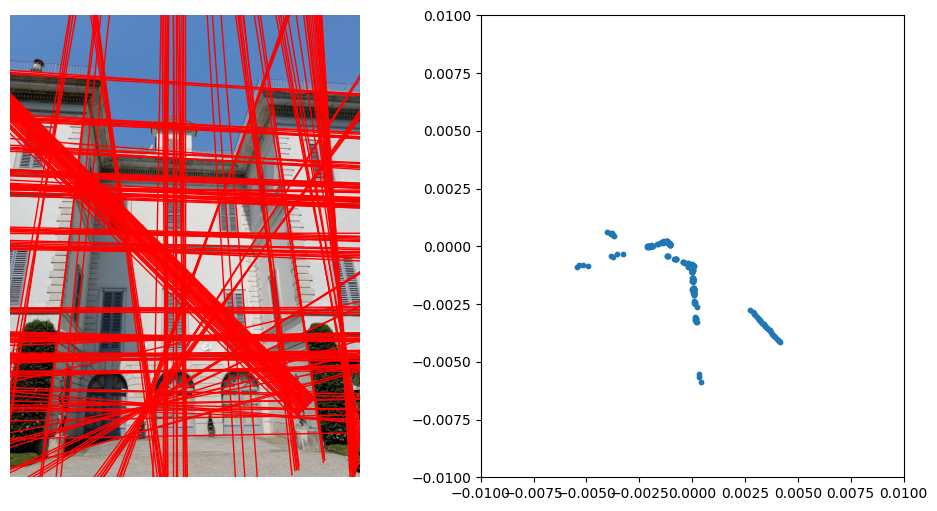

<Figure size 640x480 with 0 Axes>

In [20]:
standard_lines, inhomogeneous_lines, _, lines_to_plot = preprocess_lines(image, 7, 1.5, 1, np.pi/360, 170)

In the above plots we show, on the left, the set of lines selected with the chosen Hough Parameters, plotted directly on the image. On the right, we show the representation of the lines as points in the dual space. <br>
Let me again remark that finding a line in the dual space that has a large consensus set (and hence that passes through or near many points) is equivalent to finding a point in the original space through or near which many lines pass.

In [25]:
vanishing_points, clusters = sequential_ransac(3, inhomogeneous_lines, 0.00003) 

CLUSTER 0 DONE
CLUSTER 1 DONE
CLUSTER 2 DONE


/var/folders/bh/t8gv35mx1611w2zhw193n0lh0000gn/T/ipykernel_21390/252108370.py:10: RuntimeWarning: divide by zero encountered in divide
  y_values = (-a * x_values - c) / b


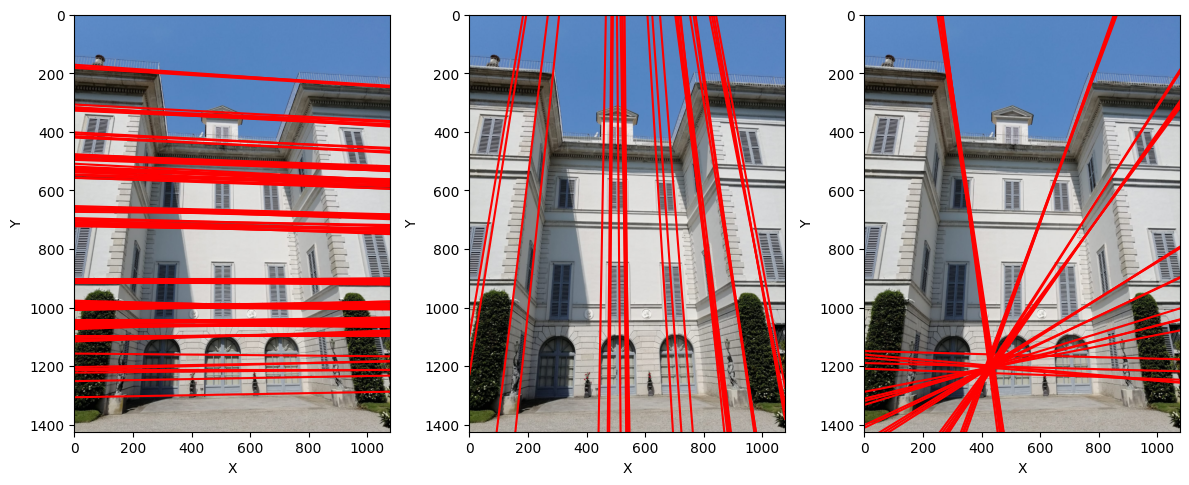

In [26]:
plot_clusters(clusters, image)

In [27]:
vanishing_points

[array([1.25584579e+04, 9.85743504e+02, 1.00000000e+00]),
 array([ 4.92880107e+02, -1.84714402e+03,  1.00000000e+00]),
 array([4.34620226e+02, 1.19562754e+03, 1.00000000e+00])]

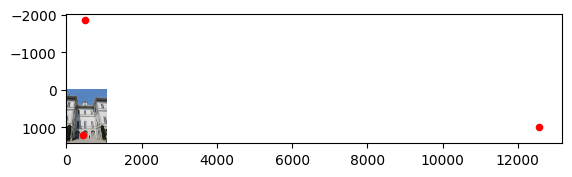

In [28]:
plot_image_with_vanishing_points(image[:, :, ::-1], vanishing_points)

In the image above, we can see the vanishing points represented on the image.

/var/folders/bh/t8gv35mx1611w2zhw193n0lh0000gn/T/ipykernel_21390/3557348415.py:8: RuntimeWarning: divide by zero encountered in divide
  y_values = (-a * x_values - c) / b


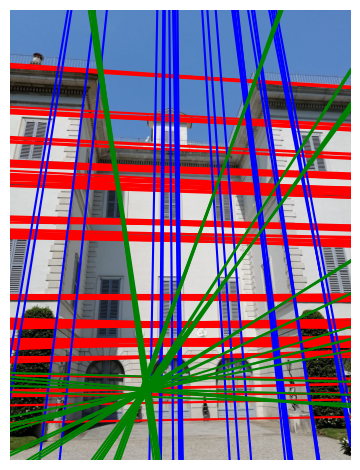

In [29]:
plot_dominant_lines_together(image, clusters)

In [30]:
len([element for cluster in clusters for element in cluster])

153

In this final image, we should the dominant lines detected through robust fitting, colored in different ways based on the cluster to which they belong.

### CONCLUSION

In conclusion, we obtained satisfactory results in for this track, as we have solved both point a and b by first obtaining the lines present in the picture using the Hough Transform, and then applying robust fitting to find best fitting intersection points and the corresponding clusters of lines. The most relevant clusters represented the set of lines parallel to each others in the real world, and the three clusters are orthogonal to each other. <br>
It shall also be remarked that we obtained a high number of dominant lines in the picture (155), and that the clusters are very homogenous and only contain lines parallel to each other, as shown by the numerous plots.